## Variational autoencoder

- Variational inference
    - A problem of finding a variational distribution $q(z|x)$ to approximate  the true posterior $p(z | x)$
<p class="text-center">$q(z | x) = \arg\min_{q} \text{KL}(q(z | x) | p(z | x))$</p>
    - <p class="text-center">$\text{KL}(q(z|x) | p(z|x)) = \mathbb{E}_{q(z|x)}\left[\ln\frac{q(z|x)}{p(z|x)}\right]$</p>
<p class="text-center">$= \mathbb{E}_{q(z|x)}[\ln q(z|x)] - \mathbb{E}_{q(z|x)}[\ln p(z|x)]$</p>
<p class="text-center">$= \mathbb{E}_{q(z|x)}[\ln q(z|x)] - \mathbb{E}_{q(z|x)}[\ln p(z,x)] + \ln p(x)$.</p>

- $\ln p(x) = \text{KL}(q(z|x) | p(z|x)) + \mathcal{L}$, $ \quad \ln p(x) \geq \mathcal{L}$
    - <p class="text-center">where, $\mathcal{L} = - \mathbb{E}_{q(z|x)}[\ln q(z|x)] + \mathbb{E}_{q(z|x)}[\ln p(z,x)]$</p>
<p class="text-center">$= - \mathbb{E}_{q(z|x)}[\ln q(z|x)] + \mathbb{E}_{q(z|x)}[\ln p(z)] + \mathbb{E}_{q(z|x)}[\ln p(x|z)]$</p>
<p class="text-center">$= - \text{KL}(q(z|x) | p(z)) + \mathbb{E}_{q(z|x)}[\ln p(x|z)]$</p>

- This is ELBO(evidence lower bound) because $p(x)$ is 'evidence'.
- $\mathbb{E}_{q(z|x)}[\ln p(x|z)]$: data likelihood
- $\text{KL}(q(z|x) | p(z))$: regularizer
    - with diagonal covariance assumption: <p>$\text{KL}(N((\mu_1,…,\mu_k)^T, diag(\sigma_1^2,…,\sigma_k^2))|N(0,I)) = \frac{1}{2}\sum_{i=1}^k(\sigma_i^2+\mu_i^2-ln(\sigma_i^2)-1]$</p>

<img src=attachment:image.png width=300>
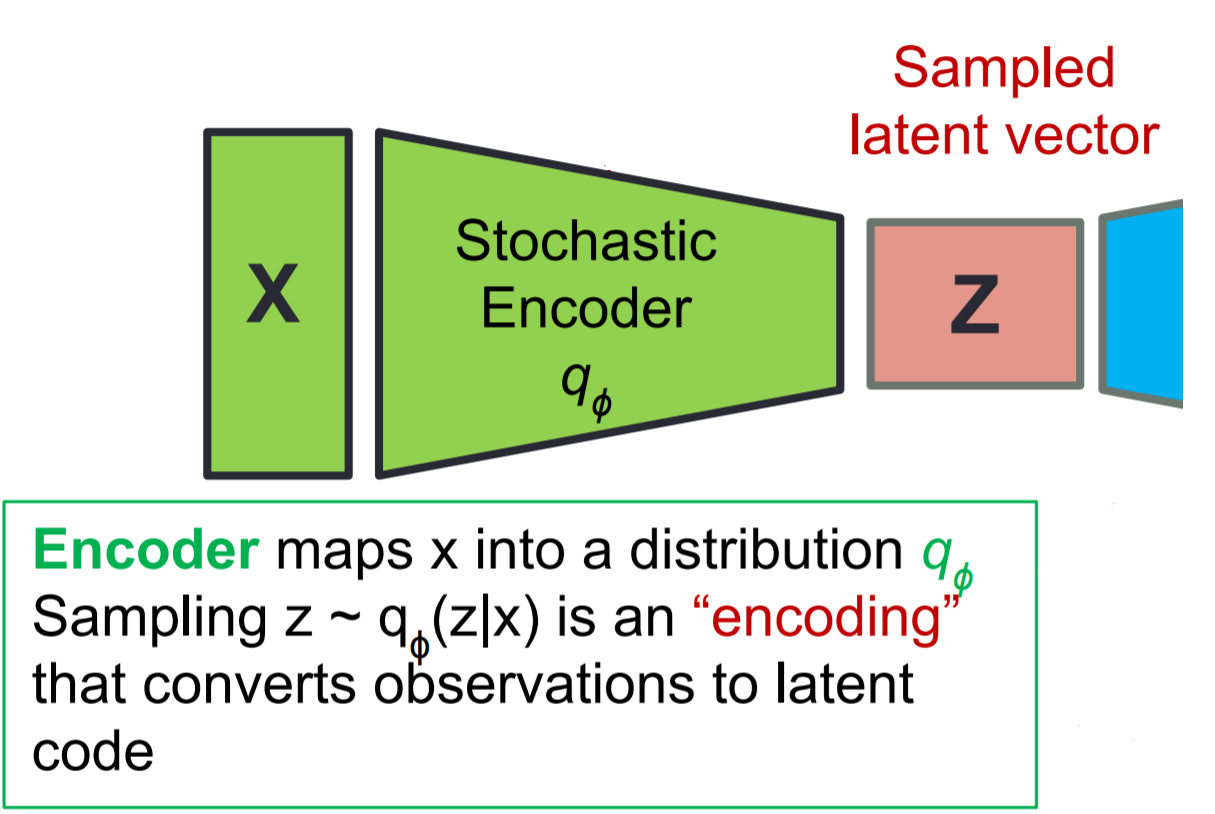

- standard AE 
    - maps the input into a *fixed vector*.
    - latent space where their encoded vectors lie, may not be continuous, very sparse.
    - if randomly pick $z \in \mathbb{R}^{100}$ from learned 100-dim $z$ with standard AE, Decoder($z$) wouldn't generate good images since most of $z$s in the whole 100-dim space are meaningless.
    - the latent vector space is sparse. That means, we can’t sample randomly from that space and expects a vector producing a valid image.
- In variational autoencoder, we represent each latent attribute for a given input as a probability distribution. When decoding from the latent state, we'll randomly sample from each latent state distribution.
    - it forces the latent space to be continuous so that we can pick a random vector and get a meaningful image from it. 

<img src=attachment:image.png width=700><center>*source: https://www.jeremyjordan.me/variational-autoencoders/</center>
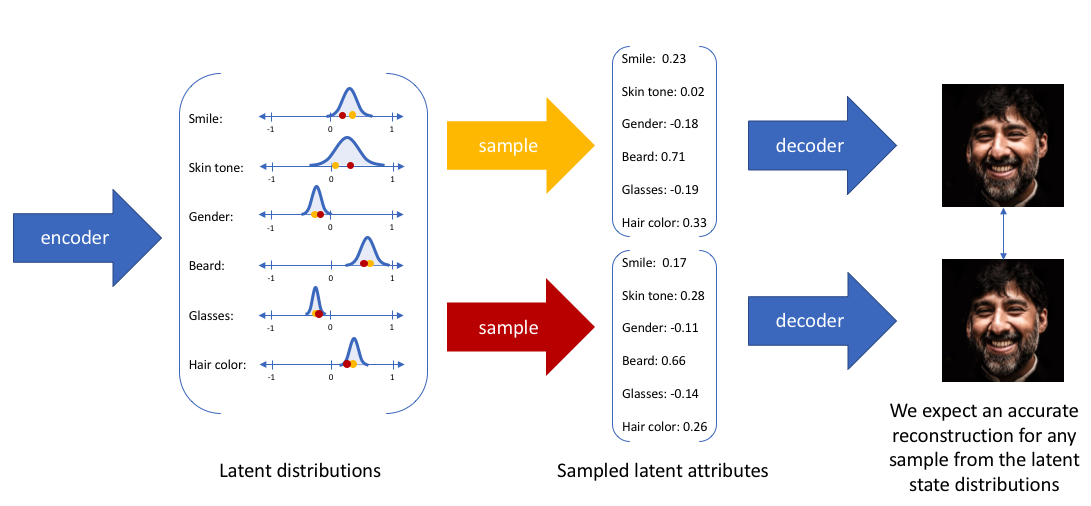

<img src=attachment:image.png width=600><center>*source:https://www.jeremyjordan.me/variational-autoencoders/</center>
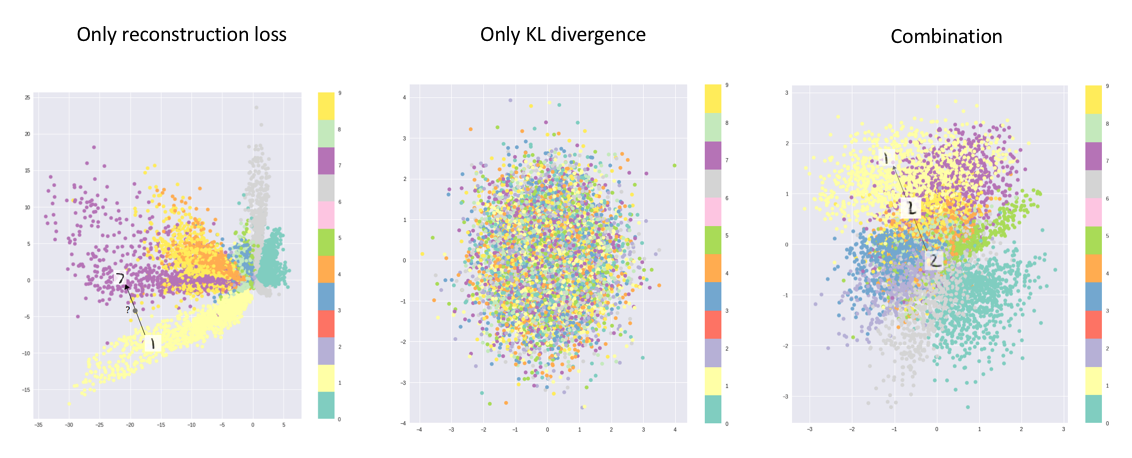

<img src=attachment:image.png width=550><center>*source: https://www.jeremyjordan.me/variational-autoencoders/</center>
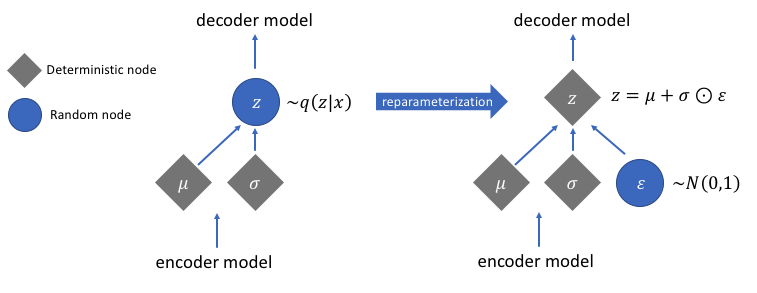

In [1]:
%matplotlib inline

import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from torchvision import datasets, transforms
device = torch.device("cuda:0")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [3]:
lr = 0.001
hidden_dim = 400
z_dim = 20

In [4]:
class Encoder(nn.Module):
    """ 
    outputs are the mean, std of the latent variable z.
    """
    def __init__(self, image_size, hidden_dim, z_dim):
        super(Encoder, self).__init__()

        self.linear = nn.Linear(image_size, hidden_dim)
        self.mu_fc = nn.Linear(hidden_dim, z_dim)
        self.log_var_fc = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        out = F.relu(self.linear(x))
        mu, log_var = self.mu_fc(out), self.log_var_fc(out)
        return mu, log_var

In [5]:
class Decoder(nn.Module):
    """ 
    Input is a reparametrized latent representation.
    """
    def __init__(self, z_dim, hidden_dim, image_size):
        super(Decoder, self).__init__()

        self.linear1 = nn.Linear(z_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, image_size)

    def forward(self, z):
        out = F.relu(self.linear1(z))
        reconstructed = torch.sigmoid(self.linear2(out))
        return reconstructed

In [6]:
class VAE(nn.Module):
    
    def __init__(self, image_size=784, hidden_dim=hidden_dim, z_dim=z_dim):
        super(VAE, self).__init__()

        self.__dict__.update(locals())

        self.encoder = Encoder(image_size=image_size, hidden_dim=hidden_dim, z_dim=z_dim).to(device)
        self.decoder = Decoder(z_dim=z_dim, hidden_dim=hidden_dim, image_size=image_size).to(device)

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        out_img = self.decoder(z)
        return out_img, mu, log_var

    def reparameterize(self, mu, log_var):
        """" Reparametrization trick: z = mean + std*epsilon,
             where epsilon ~ N(0, 1).
        """
        epsilon = torch.randn(mu.shape).to(device)
        z = mu + epsilon * torch.exp(log_var/2) # 2 for convert var to std
        return z

In [7]:
model = VAE().to(device)

In [8]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
def show(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [11]:
def reconstruct_images(model, images, save=False):
    # Reshape images, pass through model, reshape reconstructed output
    images = images[:64]
    batch = images.view(images.shape[0], -1).to(device)
    reconst_images, _, _ = model(batch)
    reconst_images = reconst_images.view(-1,1,28,28)

    img = make_grid(reconst_images, nrow=int(reconst_images.shape[0]**0.5))    
    show(img)

In [12]:
def sample_images(num_images=36, save=False):
    # Random sample z
    z = torch.randn(num_images, z_dim).to(device)    
    sample = model.decoder(z)
    sample = sample.view(-1,1,28,28)
    img = make_grid(sample, nrow=int(num_images**0.5))    
    show(img)

In [13]:
def sample_interpolated_images():

    # Sample latent vectors
    z1 = torch.normal(torch.zeros(z_dim), 1)
    z2 = torch.normal(torch.zeros(z_dim), 1)
    num_imgs = 16
    samples = torch.zeros((num_imgs, 1, 28, 28))
    
    # Interpolate within latent vectors
    for idx, alpha in enumerate(np.linspace(0, 1, num_imgs)):
        z = (alpha*z1 + (1-alpha)*z2).to(device)
        sample = model.decoder(z)
        sample = sample.view(-1,1,28,28)
        samples[idx] = sample
        
    img = make_grid(samples, nrow=num_imgs)
    show(img)

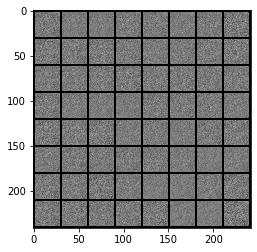

epoch:0, itr:0, loss:23606.4765625


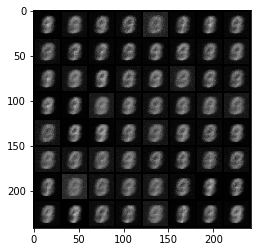

epoch:0, itr:50, loss:7021.29150390625


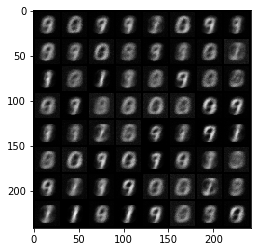

epoch:0, itr:100, loss:6596.39990234375


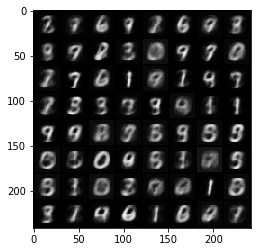

epoch:0, itr:150, loss:5670.7822265625


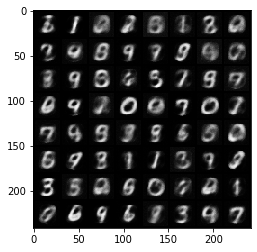

epoch:0, itr:200, loss:5490.5400390625


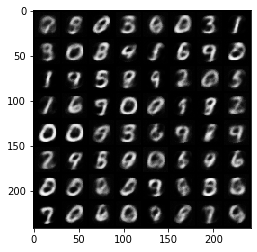

epoch:0, itr:250, loss:5265.64990234375


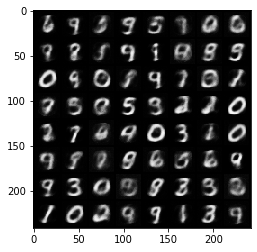

epoch:0, itr:300, loss:5344.40185546875


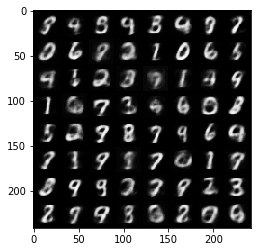

epoch:0, itr:350, loss:5103.45263671875


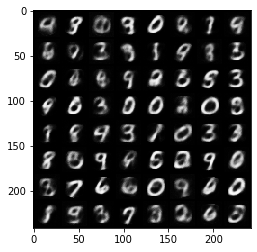

epoch:0, itr:400, loss:4800.24755859375


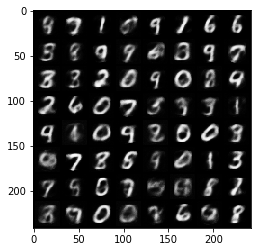

epoch:0, itr:450, loss:4733.443359375
epoch:0, loss:3641.6318359375
epoch:1, loss:3231.880859375
epoch:2, loss:3117.37451171875
epoch:3, loss:2983.727294921875
epoch:4, loss:3039.92138671875


In [14]:
for epoch in range(5):
    model.train()

    for itr, data in enumerate(train_loader):
        
        img, label = data
        img = img.view(img.shape[0],-1).to(device)
        out_img, mu, log_var = model(img)
        
        recon_loss = torch.sum((img-out_img)**2)
        kl_divergence = torch.sum(0.5*(mu**2 + torch.exp(log_var)-log_var-1))
        
        loss = recon_loss + kl_divergence
        
        optimizer.zero_grad()                
        loss.backward()
        optimizer.step()
        
        if itr%50==0 and epoch==0:
            reconstruct_images(model, img)
            print('epoch:{}, itr:{}, loss:{}'.format(epoch, itr, loss.item()))
    print('epoch:{}, loss:{}'.format(epoch, loss.item()))

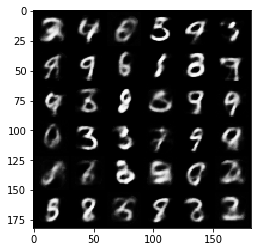

In [19]:
sample_images()

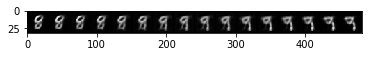

In [24]:
sample_interpolated_images()